# LSTM = Time Series Dataset
- 서울시 기후 데이터: 2011년 01월 01일 ~ 2019년 12월 31일
- https://data.kma.go.kr/cmmn/main.do
- 기후통계분석 -> 기온분석 -> 기간(20110101 ~ 20191231) -> 검색 -> csv 다운로드
- Seoul_Temp.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [5]:
!nvidia-smi

Fri Mar 26 04:57:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [7]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


## 2. Data Preprocessing

### 1) 일일 평균온도('avg') 변화 시각화
- 일일 평균온도 변화에 일정한 패턴 확인

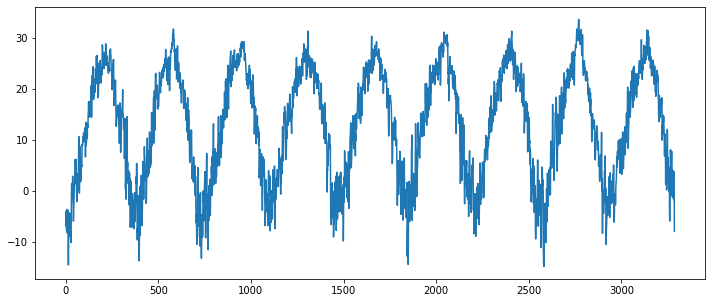

In [8]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

### 2) Normalization
- tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [9]:
scaler = MinMaxScaler(feature_range = (-1, 1)) # -1 ~ 1 사이로 scaling

temp_data = scaler.fit_transform(temp_data)

### 3) Train Test Split
- Train Dataset: 2011년 01월 01일 ~ 2017년 12월 31일
- Test Dataset: 2018년 01월 01일 ~ 2019년 12월 31일

In [10]:
train = temp_data[0:2557] # X, y가 분리된 상태는 아님
test = temp_data[2557:]

## 3. 시계열 데이터 처리함수

### 1) 시계열 학습용 데이터 생성 함수 정의
- X: 학습 평균온도 데이터
- y: 정답 평균온도 데이터
- 일정기간의 X로 y를 예측하도록 학습

In [11]:
def create_dataset(time_data, loop_back = 1) :
  data_X, data_y = [] , []

  for i in range(len(time_data) - loop_back) :
    data_X.append(time_data[i : (i + loop_back), 0])
    data_y.append(time_data[i + loop_back, 0])

  return np.array(data_X) , np.array(data_y)

### 2) loop_back 기간 설정 후 학습데이터 생성
- 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [12]:
loop_back = 180

X_train, y_train = create_dataset(train, loop_back)
X_test, y_test = create_dataset(test, loop_back)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2377, 180), (550, 180), (2377,), (550,))

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# 180번 sequence를 돌도록 reshape

((2377, 180, 1), (550, 180, 1), (2377,), (550,))

## 4. LSTM Modeling

### 1) Model Define & Compile
- dropout: 층의 입력에 대한 드롭아웃 비율을 정함
- recurrent_dropout: 순환상태의 드롭아웃 비율을 정함
- Model 1: one layer, loop_back 180

In [15]:
model = Sequential()

model.add(Bidirectional(LSTM(64,        # LSTM을 Bidirectional로 감쌈
                             input_shape = (None, 1))))
model.add(Dense(1, activation = 'tanh'))

In [17]:
model.compile(loss = 'mse',
              optimizer = 'adam')

In [37]:
model_2 = Sequential()

# LSTM을 Bidirectional로 감쌈
model_2.add(Bidirectional(LSTM(64,
                               dropout = 0.1,
                               input_shape = (None, 1),
                               return_sequences = True)))
model_2.add(Bidirectional(LSTM(64,
                               input_shape = (None, 1),
                               return_sequences = False)))
model_2.add(Dense(1, activation = 'tanh'))

In [38]:
model_2.compile(loss = 'mse',
              optimizer = 'adam')

### 2) Model Fit

In [19]:
%%time

hist = model.fit(X_train, y_train,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (X_test, y_test))

Epoch 1/200
149/149 [==============================] - 37s 19ms/step - loss: 0.0521 - val_loss: 0.0153
Epoch 2/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0168 - val_loss: 0.0141
Epoch 3/200
149/149 [==============================] - 2s 14ms/step - loss: 0.0149 - val_loss: 0.0117
Epoch 4/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 5/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0111 - val_loss: 0.0090
Epoch 6/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 7/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 8/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 9/200
149/149 [==============================] - 2s 14ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 10/200
149/149 [==============================] - 2s 14ms/step - loss: 0.00

In [39]:
%%time
hist_2 = model_2.fit(X_train, y_train,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (X_test, y_test))

Epoch 1/200
149/149 [==============================] - 11s 37ms/step - loss: 0.0358 - val_loss: 0.0140
Epoch 2/200
149/149 [==============================] - 4s 25ms/step - loss: 0.0154 - val_loss: 0.0116
Epoch 3/200
149/149 [==============================] - 4s 27ms/step - loss: 0.0140 - val_loss: 0.0121
Epoch 4/200
149/149 [==============================] - 4s 28ms/step - loss: 0.0129 - val_loss: 0.0110
Epoch 5/200
149/149 [==============================] - 4s 24ms/step - loss: 0.0124 - val_loss: 0.0101
Epoch 6/200
149/149 [==============================] - 4s 25ms/step - loss: 0.0123 - val_loss: 0.0097
Epoch 7/200
149/149 [==============================] - 4s 25ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 8/200
149/149 [==============================] - 4s 24ms/step - loss: 0.0124 - val_loss: 0.0091
Epoch 9/200
149/149 [==============================] - 4s 24ms/step - loss: 0.0116 - val_loss: 0.0097
Epoch 10/200
149/149 [==============================] - 4s 25ms/step - loss: 0.01

### 3) Visualization

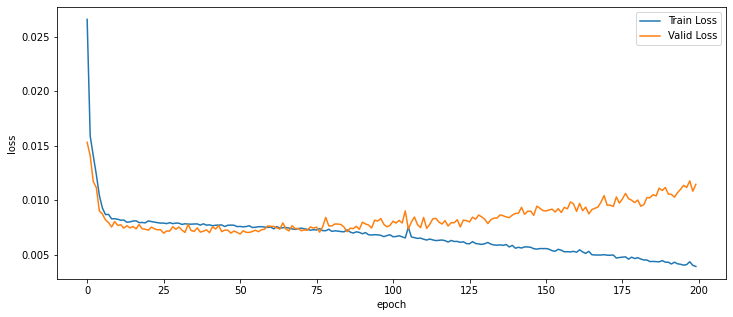

In [20]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss' , 'Valid Loss'] , loc = 'upper right')
plt.show()

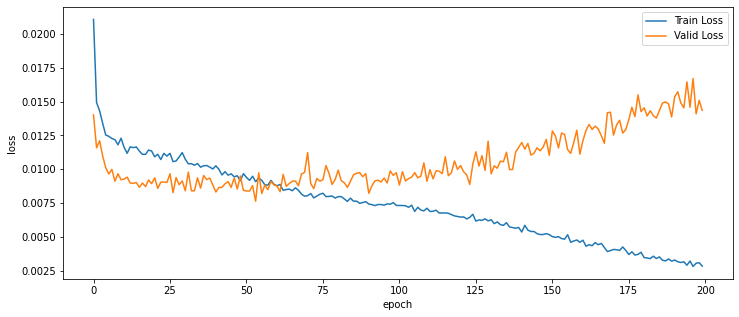

In [40]:
plt.figure(figsize = (12, 5))
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss' , 'Valid Loss'] , loc = 'upper right')
plt.show()

### 4) Model Evaluate

In [21]:
train_score = model.evaluate(X_train, y_train, verbose = 0)
print('Train Score: ' , train_score)

test_score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score: ' , test_score)

Train Score:  0.0037085541989654303
Test Score:  0.011447252705693245


In [41]:
train_score = model_2.evaluate(X_train, y_train, verbose = 0)
print('Train Score: ' , train_score)

test_score = model_2.evaluate(X_test, y_test, verbose = 0)
print('Test Score: ' , test_score)

Train Score:  0.0030365718994289637
Test Score:  0.014352346770465374


## 4. Model Predict

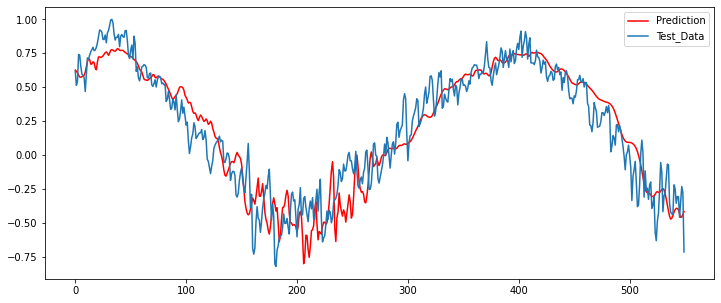

In [22]:
look_ahead = 550

xhat = X_test[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead) :
  prediction = model.predict(np.array([xhat]), batch_size = 1)
  predictions[i] = prediction
  xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label = 'Test_Data')
plt.legend()

plt.show()